## Imports and read

In [211]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import nltk
import random
import gensim
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import *
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import describe

In [165]:
wine = pd.read_csv('./winemag-data-130k-v2.csv', index_col=0)

In [166]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


#description and reviews are the important columns; lets remove duplicates and NA in desccription
df_wine.drop_duplicates('description',inplace = True)
df_wine.dropna(subset=['description', 'price', 'points'], inplace = True)

#### Exploratory analysis
Visualization 1

In [167]:
wine.isnull().sum(axis=0)

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

Looking for NA values, we see a lot of NA values. Especially for region and taster attributes. We can safely drop these as they should not affect the review.

In [168]:
wine.drop(columns=['region_1', 'region_2', 'taster_name', 'province',
                   'taster_twitter_handle', 'designation',
                  'title', 'winery'], inplace=True)

In [169]:
wine.columns

Index(['country', 'description', 'points', 'price', 'variety'], dtype='object')

These columns should explain the highest variance, others would cause only small increments in accuracy. Dropping all those will hurt accuracy, but not as much. Doing so reduces the number of parameters to estimate. 

/home/nischal/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nischal/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


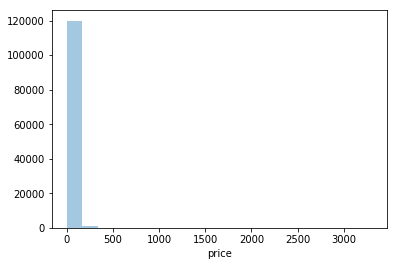

In [170]:
sns.distplot(wine.price, bins=20, kde=False)

prices have very high skew, using a log transformation

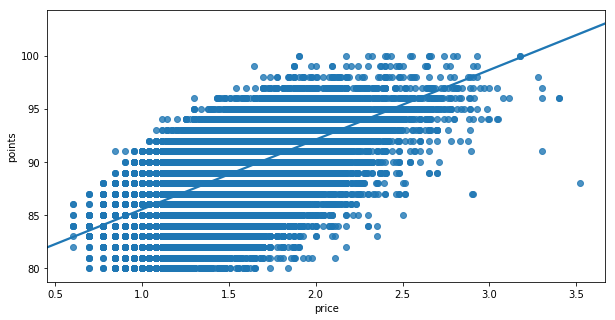

In [171]:
plt.figure(figsize = (10, 5))
sns.regplot(x = np.log10(wine.price), y = wine.points)

A good positive relation between price and points (looks like an expensive wine scores better)

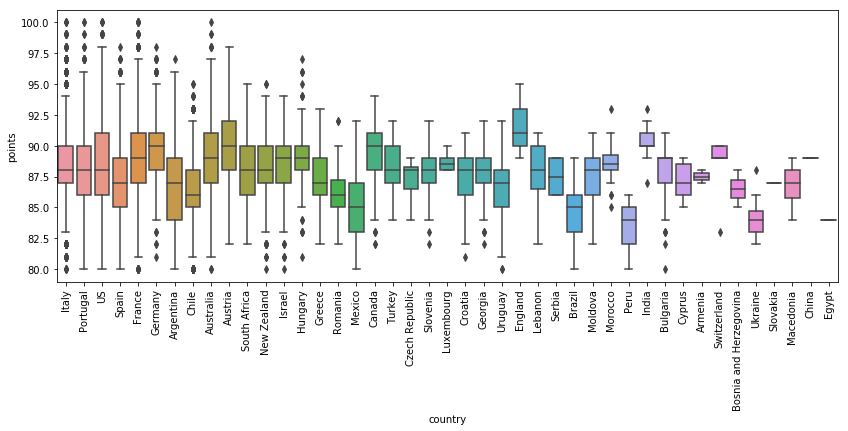

In [172]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=wine.country, y=wine.points)
plt.xticks(rotation=90)
plt.show()

Not a very good separation, but should help the model

## Data Preprocessing

In [203]:
dummy = pd.get_dummies(wine.loc[:, ['country', 'variety']])
wine_processed = wine.drop(['country', 'variety'], axis=1)
wine_processed = pd.concat([wine_processed, dummy], axis=1)

In [204]:
wine_processed.price.fillna(wine_processed.price.mean(), inplace=True)
wine_processed['price'] = np.log10(wine_processed.price)
wine_processed['price'] = StandardScaler().fit_transform(wine_processed.price.values.reshape(-1, 1))

In [227]:
## standard nltk functions for text preprocessing 

nltk.download('wordnet')
def tokenize_(text):
    tokens = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>3:
            _tokens = WordNetLemmatizer().lemmatize(token, pos = 'v')
            tokens.append(_tokens)
    return tokens

def tokenize(text_raw):
    tokens = []
    for i, line in enumerate(text_raw):
        tokens.append(tokenize_(line))
    return tokens

def get_dict(doc):
    return gensim.corpora.Dictionary(doc)

def generate_bow(doc_list):
    doc_dict = get_dict(doc_list)
    doc_bow = [doc_dict.doc2bow(line) for line in doc_list]
    return doc_bow, doc_dict

def run_lda(n_topics, doc_tfidf, doc_dict, verbose=False):
    doc_lda = gensim.models.LdaMulticore(doc_tfidf, num_topics = n_topics, id2word = doc_dict,
                                         passes = 3, minimum_probability=0.0)
    
    if verbose: 
        for i, t in doc_lda.print_topics(-1):
            print('Topic: {} Word: {} '.format(i,t))
        
    doc_topic_dist_tup = doc_lda.get_document_topics(doc_tfidf, minimum_probability=0.0)
    doc_topic_prob = np.zeros(shape= (len(doc_topic_dist_tup), n_topics), dtype = "float64")
    for i, top_dist in enumerate(doc_topic_dist_tup):
        doc_topic_prob[i,:] = np.asarray(top_dist)[:,1]
        
    return doc_topic_prob

[nltk_data] Downloading package wordnet to /home/nischal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [225]:
tokenized_desc = tokenize(wine_processed.description)
desc_bow, desc_dict = generate_bow(tokenized_desc)
tf = models.TfidfModel(desc_bow)
desc_tfidf = tf[desc_bow]

In [228]:
%%time
topic_probs = run_lda(10, desc_tfidf, desc_dict)

In [237]:
## covert to a dataframe and concat on original
topics = ['topic_' + str(i) for i in range(1, 11)]
topics_df = pd.DataFrame(topic_probs, columns=topics)
wine_processed.drop('description', axis=1, inplace=True)
wine_processed = pd.concat([wine_processed, topics_df], axis=1)

In [240]:
wine_processed.shape

(129971, 762)

In [241]:
# split into train and test
train = wine_processed.sample(frac=0.8, random_state = 666)
test = wine_processed.drop(train.index)

In [242]:
train.shape, test.shape

((103977, 762), (25994, 762))

In [248]:
def split(data):
    X = data.loc[:, data.columns != 'points']
    y = data.points
    return X, y.values.reshape(-1, 1)
    
train_X, train_y = split(train)
test_X, test_y = split(test)

## Models

### Lasso

In [264]:
from sklearn.linear_model import LassoCV

In [274]:
lasso_cv = LassoCV(alphas=[0.001, 0.01, 1, 10, 100], 
                   verbose=1, copy_X=True, cv=10, n_jobs=6)

In [275]:
%%time
cv_res = lasso_cv.fit(train_X, train_y.reshape(-1, ))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
..................................................[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   13.8s finished


CPU times: user 1min 17s, sys: 17.6 s, total: 1min 34s
Wall time: 16 s


In [279]:
cv_res.score(test_X, test_y)

0.40721125031068983

In [343]:
lasso_coef = pd.DataFrame(data={'names': train_X.columns, 'score': cv_res.coef_})
imp_score = lasso_coef.loc[abs(lasso_coef.score) > 0.25, :]

In [344]:
imp_score.names.iloc[imp_score.score.argsort().values[:5]]

751                    topic_1
758                    topic_8
165    variety_Champagne Blend
369           variety_Meritage
536               variety_Rosé
Name: names, dtype: object

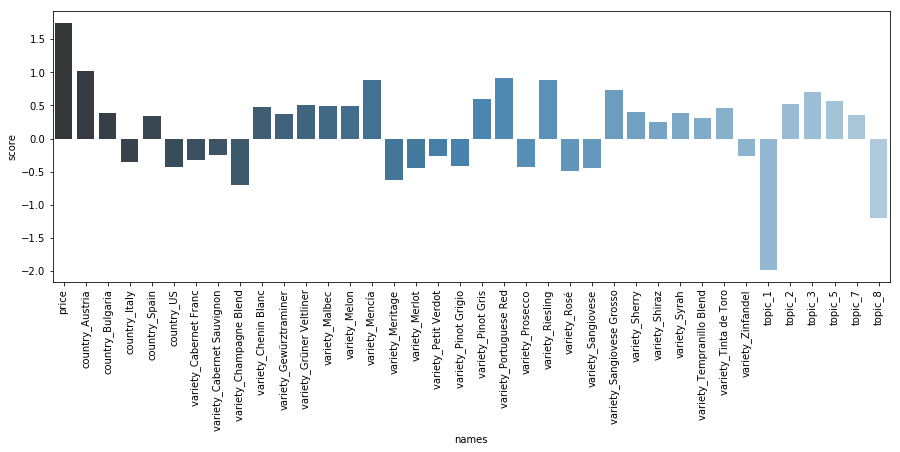

In [345]:
plt.figure(figsize=(15, 5))
sns.barplot(x=imp_score.names, y=imp_score.score, palette="Blues_d")
plt.xticks(rotation=90)
plt.show()

In [346]:
from sklearn.svm import LinearSVR

In [347]:
svr = LinearSVR()
svr.fit(train_X, train_y)

/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [349]:
svr.score(train_X, train_y)

0.41605638696286906

In [249]:
#grid search CV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

In [259]:
def call_gridsearch(clf, X, y, param_grid, scoring, filename):
    gs = GridSearchCV(clf, cv = 10, param_grid=param_grid, scoring=scoring, 
                      verbose = 5, refit = 'r2', n_jobs = 6)
    gs.fit(X, y)
    cv_results = pd.DataFrame(gs.cv_results_)
    cv_results.to_pickle(filename)
    return cv_results

In [260]:
clf_ridge = Ridge()
params = {'alpha' : [0.1, 0.01, 0.001, 1]}
scoring = {'r2' : make_scorer(r2_score)}
cv_ridge = call_gridsearch(clf_ridge, train_X, train_y, params, scoring, 'ridge')

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    6.1s
[Parallel(n_jobs=6)]: Done  38 out of  40 | elapsed:   33.1s remaining:    1.7s
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   34.4s finished
/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/utils/depr

In [257]:
cv_ridge.

0    5.343604
1    5.343486
2    5.343464
3    5.347264
Name: mean_train_mse, dtype: float64

In [263]:
from sklearn.linear_model import RidgeCV

In [163]:
from sklearn.ensemble import RandomForestRegressor

In [181]:
clf_rf = RandomForestRegressor(random_state=100)

In [177]:
clf_rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=100, verbose=0, warm_start=False)

In [178]:
pred = clf_rf.predict(test.iloc[:, test.columns!='points'])

In [179]:
mean_squared_error(pred, test.points)

3.788441124008425

In [180]:
r2_score(pred, test.points)

0.36211334790220495

In [ ]:
param_rf = {'n_estimators': [10, 20, 30, 50, 100, 200],
           'max_features': ['sqrt', 'log2']}
cv_rf = call_gridsearch(clf_rf, param_rf, scoring, 'rf')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] max_features=sqrt, n_estimators=10 ..............................
[CV] max_features=sqrt, n_estimators=10 ..............................
[CV] max_features=sqrt, n_estimators=10 ..............................
[CV] max_features=sqrt, n_estimators=10 ..............................
[CV]  max_features=sqrt, n_estimators=10, mse=4.411275923021386, r2=0.5444042228791559, total=  25.6s
[CV] max_features=sqrt, n_estimators=10 ..............................
[CV]  max_features=sqrt, n_estimators=10, mse=4.379129509298677, r2=0.5367246156824157, total=  26.0s
[CV] max_features=sqrt, n_estimators=10 ..............................
[CV]  max_features=sqrt, n_estimators=10, mse=4.46477199620048, r2=0.5283281427725877, total=  26.2s
[CV] max_features=sqrt, n_estimators=10 ..............................
[CV]  max_features=sqrt, n_estimators=10, mse=4.346326856623597, r2=0.5491079292016514, total=  26.2s
[CV] max_features=sqrt, n_estimat

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min


[CV]  max_features=sqrt, n_estimators=20, mse=4.146250210498669, r2=0.5717760303926365, total= 1.1min
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV]  max_features=sqrt, n_estimators=20, mse=4.126202726982199, r2=0.5640956122308742, total= 1.1min
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV]  max_features=sqrt, n_estimators=20, mse=4.130515339706724, r2=0.5630259216200322, total= 1.1min
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV]  max_features=sqrt, n_estimators=20, mse=4.133901944382203, r2=0.571145091092436, total= 1.1min
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV]  max_features=sqrt, n_estimators=20, mse=4.151461551945222, r2=0.5686249636236961, total= 1.0min
[CV] max_features=sqrt, n_estimators=20 ..............................
[CV]  max_features=sqrt, n_estimators=20, mse=4.191353447499458, r2=0.5680365638541336, total= 1.1min
[CV] max_features=sqrt, n_estimato

NameError: name 'cv_rf' is not defined